# Exercice 3 - Entraînement d'un classifieur

Vous avez vu comment mettre en place une descente de gradient stochastique ; il est temps maintenant de créer un réseau de neurones et de l'entraîner.

## Quid des données ?

En général, pour traiter des images, du texte, du son ou de la vidéo, il est possible d'utiliser des packages python standards pour charger les données dans un tableau numpy. On peut ensuite convertir ce tableau en tenseur ``torch.*Tensor``.

En traitement d'image, il existe un package appelé ``torchvision``, qui permet de charger des bases de données standard, telles que CIFAR10, ImageNet, MNIST, etc..

Dans ce TP, nous utiliserons le dataset MNIST, que vous avez déjà manipulé en Analyse de Données en première année. Les images MNIST sont des images en niveaux de gris, de taille 28x28 pixels, représentant des chiffres manuscrits de 0 à 9.

![mnist](http://i.ytimg.com/vi/0QI3xgXuB-Q/hqdefault.jpg)
   
## Entraînement d'un classifieur d'image

Nous suivrons les étapes suivantes :
1. Chargement et préparation des données d'entraînement et de test de la base de données MNIST.
2. Définition d'un simple perceptron monocouche
3. Définition d'une fonction de coût
4. Entraînement du perceptron sur les données d'entraînement
5. Test du perceptron sur les données de test

## 1. Chargement et préparation des données

On peut charger les données MNIST en utilisant le package ``torchvision``.

In [2]:
# Inclure les fonction d'affichage "print"
from __future__ import print_function
# Inclure numpy abrégée np
import numpy as np
# Inclure les fonction d'affichage "plot" abrégée plt
from matplotlib import pyplot as plt
# Inclure torch
import torch
# Inclure torchvision
import torchvision
# Inclure torchvision.transforms abrégé transforms
import torchvision.transforms as transforms
# Inclure Variable
from torch.autograd import Variable

# %matplotlib inline

On souhaite convertir en tenseurs et normaliser dans l'intervalle [-1, 1] les images que l'on va charger.

In [3]:
# Déclaration de 'transform' pour convertir en tenseur et normaliser
transform = transforms.Compose(
    [transforms.ToTensor(), # Conversion en tenseur
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalisation

**Téléchargement des données MNIST sur le disque**

In [4]:
# Base de données d'entraînement
trainset = torchvision.datasets.MNIST(root='~/../../mnt/n7fs/ens/tp_carlier/data', train=True, download=True, transform=transform)
# Version hors réseau N7 : A UTILISER SUR VOTRE MACHINE PERSONNELLE (va télécharger les données)
# trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Base de données de test
testset = torchvision.datasets.MNIST(root='~/../../mnt/n7fs/ens/tp_carlier/data', train=False, download=True, transform=transform)
# Version hors réseau N7 : A UTILISER SUR VOTRE MACHINE PERSONNELLE (va télécharger les données)
# testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Définition des 10 noms de classes (chiffres)
class_names = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

**Définition de la fonction 'show_image' pour afficher les images**

In [5]:
def show_image(im, classno):
    
    # Remettre en forme de l'image entre 0 et 1 avec la bonne taille
    im_npy = im.numpy().transpose(1, 2, 0) * 0.5 + 0.5
    
    # Affecter le nom de classe de l'image comme titre 
    plt.title(class_names[classno])
    
    # Afficher l'image en niveaux de gris
    plt.imshow(im_npy[:,:,0], cmap='gray') 
    
    # Masquer les axes
    plt.axis('off')

**Visualisation d'une image de l'ensemble d'apprentissage**

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

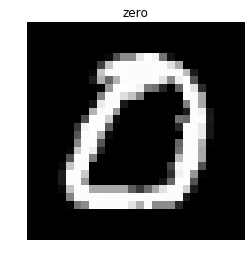

In [13]:
# Récupérer l'image 3830 de l'ensemble d'entraînement par exemple (avec son numéro de classe)
im, classno = trainset[3829]

# Afficher l'image 3830 de l'ensemble d'entraînement
show_image(im, classno)
im


## 2. Définition d'un perceptron

Voici ici la définition d'un réseau de neurones simpliste qui connecte une couche d'entrée et une couche de sortie.

In [82]:
# Inclure torch.nn abrégé nn
import torch.nn as nn
# Inclure torch.nn.functional abrégé F
import torch.nn.functional as F

# Déclaration de la classe pour le réseau de neurones
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(784, 100) # Transformation linéaire (nb entrée, nb sorties)
        # A FAIRE ----------------------------------------------------------------------------------------
        # Ajouter différentes couches dans le réseau
        #-------------------------------------------------------------------------------------------------
        self.fc1 = nn.Linear(100,70)
        self.fc2 = nn.Linear(70,50)
        self.fc3 = nn.Linear(50,30) 
        self.fc4 = nn.Linear(30,10) 
    def forward(self, x):
        x = torch.squeeze(self.fc0(x))
        # A FAIRE ------------------------------------------------------------
        # Ajouter différentes couches dans le réseau --- Changer function ? 
        #-------------------------------------------------------------------------------------------------
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        
        return x

## 3. Défnition d'une fonction de coût et d'un Optimizer

Comme vu en cours, on va utiliser l'entropie croisée comme fonction de coût pour ce problème de classification.
Pour rappel, étant donné un vecteur `x` et un identifiant de classe `class`, la fonction de coût s'écrit :

\begin{equation}
J(x,class) = -\log \, \left(\frac{e\,^{x(class)}}{\displaystyle\sum_{j=1}^{\#classes} e\,^{x(j)}}\right)
            = -x(class) + \log \, \left(\displaystyle\sum_{j=1}^{\#classes} e\,^{x(j)}\right)
\end{equation}

Comme Optimizer, on utilise la descente de gradient stochastique avec un momentum.

In [83]:
# Inclure torch.optim abrégé optim
import torch.optim as optim

# Initialiser le réseau en appelant la classe 'Net'
net = Net()

# Choisir la fonction de coût entropie croisée
criterion = nn.CrossEntropyLoss()

# Choisir pour optimiseur le modèle de descente de gradient stochastique
# L'optimiseur gère l'hyperparamètre de taux d'apprentissage "lr" (learning rate) et celui de mémoire
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## 4. Entraînement du réseau

Le code est calqué sur les exemples précédents. On dispose d'un itérateur sur nos données, et à chaque itération on calcule la sortie du réseau pour nos données, on évalue la fonction de coût et l'on rétro-propage le gradient.

In [84]:
# Objet qui définit un itérateur sur la base de données, en extrayant des mini-batches dans un ordre aléatoire
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# Le nombre d'epochs maximal définit le nombre de passages complets sur la base de données d'entraînement
epoch_max = 7
for epoch in range(epoch_max):

    # On ne va afficher le risque empirique que tous les 200 mini-batches
    running_J = 0.0
    
    for i, data in enumerate(trainloader):
        
        # Récupération les données d'entrée (mini-batch)
        inputs, labels = data
        
        # Vectorisation des images pour les fournir en entrée du réseau
        # Noter que la première dimension de 'images' correspond aux nombres d'images, la seconde au nombre de canaux 
        # par images, et ce sont seulement les 3ème et 4ème qui correspondent aux dimensions spatiales d'une image
        inputs = inputs.reshape(inputs.shape[0],inputs.shape[1],inputs.shape[2]*inputs.shape[3])      

        # Remise à zéro des gradients
        optimizer.zero_grad()

        # Passe "forward" pour calculer la prédiction du réseau 
        outputs = net(inputs)
        
        # Calculer la fonction objectif J pour un mini-batch (fonction de coût)
        J = criterion(outputs, labels)
        
        # Rétro-propagation du gradient
        J.backward()
        optimizer.step()

        # Incrémenter la valeur de la fonction objectif globale
        running_J += J.item()

        # Afficher les statistiques tous les 200 mini-batches
        if (i+1) % 200 == 0:
            print('[Epoch %d, après %5d mini-batches] > J = %.3f' % (epoch+1, i+1, running_J / 200))
            running_J = 0.0

print('Entraînement terminé')

[Epoch 1, après   200 mini-batches] > J = 1.955
[Epoch 1, après   400 mini-batches] > J = 1.068
[Epoch 1, après   600 mini-batches] > J = 0.724
[Epoch 1, après   800 mini-batches] > J = 0.445
[Epoch 1, après  1000 mini-batches] > J = 0.378
[Epoch 1, après  1200 mini-batches] > J = 0.354
[Epoch 1, après  1400 mini-batches] > J = 0.289
[Epoch 1, après  1600 mini-batches] > J = 0.308
[Epoch 1, après  1800 mini-batches] > J = 0.269
[Epoch 2, après   200 mini-batches] > J = 0.237
[Epoch 2, après   400 mini-batches] > J = 0.218
[Epoch 2, après   600 mini-batches] > J = 0.225
[Epoch 2, après   800 mini-batches] > J = 0.210
[Epoch 2, après  1000 mini-batches] > J = 0.210
[Epoch 2, après  1200 mini-batches] > J = 0.191
[Epoch 2, après  1400 mini-batches] > J = 0.208
[Epoch 2, après  1600 mini-batches] > J = 0.201
[Epoch 2, après  1800 mini-batches] > J = 0.194
[Epoch 3, après   200 mini-batches] > J = 0.162
[Epoch 3, après   400 mini-batches] > J = 0.188
[Epoch 3, après   600 mini-batches] > J 

### 5. Test du réseau sur les données de test

Nous avons entraîné le réseau de neurones en faisant 2 passes sur l'ensemble
d'entraînement complet. Nous allons maintenant vérifier ce que le réseau a
appris.

Pour ce faire, nous allons prédire la classe des données de test et comparer
ces prédictions à la vérité terrain.

Commençons par afficher des données de test.

In [ ]:
# Récupérer l'image 1 de l'ensemble de test (avec son numéro de classe)
im, classno = testset[0]

# Afficher l'image 1 de l'ensemble de test
#show_image(im, classno)

**Utilisation du réseau sur mini-batch de l'ensemble de test**

In [ ]:
# Initialiser les variables contenant les images et les numéros de classe du mini-batch que l'on va créer
images = []
gt_labels = []

# Construire un mini-batch avec les 10 premières images de l'ensemble de test
for i in range(10):
    
    # Récupérer l'image i de l'ensemble de test (avec son numéro de classe)
    im, classno = testset[i]
    
    # Ajouter l'image i dans 'images'
    images.append(im)
    
    # Ajouter le numéro de la classe de l'image i dans 'gt_labels'
    gt_labels.append(classno)
    
    # Afficher l'image i (avec une nouvelle figure à chaque image)
    show_image(im, classno)
    plt.show()
    
# Transformer 'images' de liste en tableau 3D et de 'gt_labels' de liste en vecteur
images = torch.stack(images)
gt_labels = torch.stack(gt_labels)

Voyons maintenant quelles classes sont prédites par le réseau pour ces données.

In [ ]:
# Vectoriser les images
# Noter que la première dimension de 'images' correspond aux nombres d'images, la seconde au nombre de canaux 
# par images, et ce sont seulement les 3ème et 4ème qui correspondent aux dimensions spatiales d'une image
images_reshape = images.reshape(images.shape[0],images.shape[1],images.shape[2]*images.shape[3])

# Passer les images dans le réseau
outputs = net(images_reshape)

# Afficher les énergies en sortie
with np.printoptions(precision=2, suppress=True):
    print(outputs.detach().numpy())

Les sorties sont appelées les énergies de chaque classe.
Plus l'énergie associée à une classe est élevée, plus le réseau "pense" que cette classe doit être associée à l'image d'entrée. On va donc chercher la classe de plus haute énergie pour chaque image.

In [ ]:
# Récupérer les indices des maxima d'énergies
_, predicted = torch.max(outputs, 1)

# Afficher les classes réelles et les classes estimées
print('Classes réelles des 10 premières images test :')
print([class_names[p] for p in gt_labels])
print('Classes estimées par le réseau pour les 10 premières images test :')
print([class_names[p] for p in predicted])

Les résultats sont satisfaisants. Voyons maintenant comment le réseau performe sur bases de données de test dans son ensemble.

**Utilisation du réseau sur tout l'ensemble de test**

In [ ]:
# Initialiser les compteurs du nombre d'images et de bonnes estimations
total = 0
correct = 0

# On utilise à nouveau un DataLoader pour créer des batches de données de test
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

# Estimation des classes pour des groupes de 16 images (taille du mini-batch)
for data in testloader:
    
    # Récupérer 16 images
    images, labels = data
    
    # Vectoriser les images 
    images = images.reshape(images.shape[0],images.shape[1],images.shape[2]*images.shape[3])
    
    # Passer les images dans le réseau
    outputs = net(images)
    
    # Récupérer les indices des maxima d'énergies
    _, predicted = torch.max(outputs, 1)
    
    # Incrémenter les compteurs
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Afficher la précision de l'estimation sur tout l'ensemble de test
print('Précision du réseau sur les 10000 images de test : %2d %%' % (100.0 * correct / total))

Les résultats montrent que le réseau a bien appris quelque chose ! Si le réseau prédisait les classes au hasard, il aurait statistiquement une précision d'environ 10%.

On peut regarder les performances par classe, pour déterminer si certaines classes sont plus faciles à prédire que d'autres.

In [ ]:
# Initialiser 2 listes pour compter les images dans chaque classe
class_total = list(0. for i in range(10))
class_correct = list(0. for i in range(10))

# Estimation des classes pour des groupes de 16 images (taille du mini-batch)
for data in testloader:
    
    # Récupérer 16 images
    images, labels = data
    
    # Vectoriser les images 
    images = images.reshape(images.shape[0],images.shape[1],images.shape[2]*images.shape[3])
    
    # Passer les images dans le réseau
    outputs = net(images)
    
    # Récupérer les indices des maxima d'énergies
    _, predicted = torch.max(outputs, 1)
    
    # Créer un vecteur binaire : 1 si le label estimé est le bon et 0 sinon
    c = (predicted == labels)
    
    # Incrémenter les compteurs dans les listes image par image en fonction de la classe de celle-ci
    for i in range(16):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

# Afficher la précision de l'estimation sur tout l'ensemble de test pour chacune des classes        
for i in range(10):
    print('Précision de la classe %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

Profitez maintenant du reste de la séance pour essayer d'obtenir la plus haute précision possible. Pour cela, vous pouvez essayer : 
1. D'ajouter une ou plusieurs couches cachées. Essayez de faire varier le nombre de neurones dans ces couches cachées.
2. Modifier les hyperparamètres : nombre d'epochs, taux d'apprentissage, momentum, etc.

Vous devriez obtenir sans trop de difficultés une précision supérieure à 95% !